In [6]:
from colour.models import eotf_inverse_ST2084

d_nits = 100
n100 = eotf_inverse_ST2084(100)
n1000 = eotf_inverse_ST2084(1000)
f'{n100} {n1000}'

'0.508078421517399 0.751827096247041'

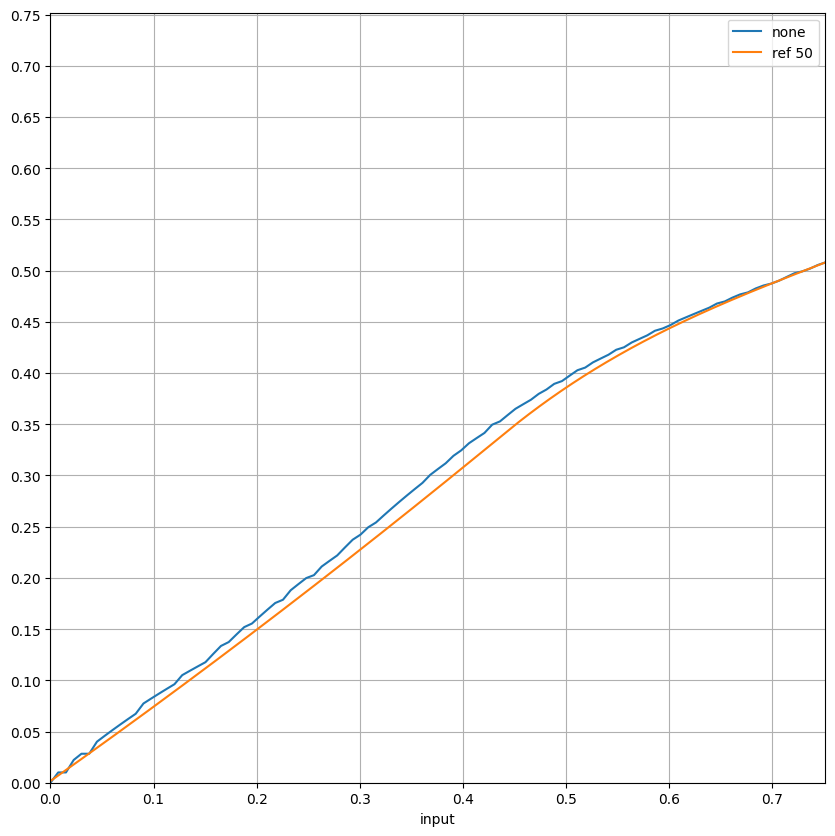

In [135]:
from colour import gamma_function, cctf_encoding
from functools import partial
from colour.models import eotf_inverse_ST2084, eotf_ST2084, oetf_BT2020, eotf_inverse_BT1886, eotf_BT1886

from typing import Dict
import numpy as np
import re

import pandas as pd

base_dir = '/media/home-media/docs/calibration/tonemapping/greyscale'
bn = f'{base_dir}/greyscale_'
names = [
    # 'jrvr_spline0', 
    # 'jrvr_spline0.2', 
    # 'jrvr_spline0.5_peak10000', 
    # 'jrvr_spline0.5_peak1000',
    # 'jrvr_spline0.5_peak100',
    # 'jrvr_spline1.0', 
    # 'madvr',
    # 'madvr_peak10000',
    # 'madvr_peak1000',
    # 'madvr_peak100',
    # 'jrvr_sdr',
    # 'madvr_sdr', 
    # 'jrvr_spline0.5_contrast0.5', 
    # 'jrvr_spline0.5_contrast1.0', 
    # 'jrvr_spline0.5_nits200', 
    # 'jrvr_splinene0.5_contrast20k',
    # 'jrvr_spline0.5_peak1000_3dlut_bt1886',
    # 'jrvr_spline0.5_peak1000_3dlut_g22',
    # 'jrvr_spline0.5_peak1000_3dlut_g24',
    'jrvr_spline0.5_peak1000_3dlut_none',
]

df_by_ds: Dict[str, pd.DataFrame] = {s: pd.read_pickle(f'{bn}{s}.pkl') for s in names}

ax = None
ref_needed = True
for s, df in df_by_ds.items():
    m = re.match(r".*peak(\d+)(_3dlut_(.*))?", s)
    max_in_nits = int(m.group(1)) if m else 1000
    lut_type = m.group(3) if m else None
    min = 0.00001
    if lut_type == 'g24':
        func = partial(gamma_function, exponent=2.4)
    elif lut_type == 'bt1886':
        func = eotf_BT1886
    else:
        func = partial(gamma_function, exponent=2.2)
    formatting = {
        'grid': True,
        'figsize': (10, 10)
    }
    # df['pq_out'] = df['avg'] ** (1.0/78.84375) 
    df['output'] = func((0.2126 * df['r'] + 0.7152 * df['g'] + 0.0722 * df['g'])) * d_nits
    df['pq_out'] = eotf_inverse_ST2084(df['output'])
    df['pq_in'] = df['percent'] / 100 * eotf_inverse_ST2084(max_in_nits)
    pq_args = {'x': 'pq_in', 'y': 'pq_out', 'label': lut_type}
    max_in_pq = eotf_inverse_ST2084(max_in_nits)
    max_out_pq = eotf_inverse_ST2084(d_nits)
    max_pq_lim = max(max_in_pq, max_out_pq)
    pq_lims = {
        'xlim': [min, max_pq_lim],
        'xticks': np.arange(min, max_pq_lim + 0.00001, 0.1),
        'ylim': [min, max_pq_lim],
        'yticks': np.arange(min, max_pq_lim + 0.00001, 0.05),
    }
    nits_lims = {
        'xlim': [min, max_in_nits],
        'xticks': np.arange(min, max_in_nits + 0.1, max_in_nits / 10),
        'ylim': [min, d_nits],
        'yticks': np.arange(min, d_nits + 0.1, d_nits / 10.0),
    }
    if ax is None:
        ax = df.plot(**pq_args, **formatting, **pq_lims)
    else:
        df.plot(**pq_args, ax=ax, **formatting, **pq_lims)
    if 'jrvr' in s and ref_needed:
        ref_data = pd.read_pickle(f'{base_dir}/s_contrast_peak{max_in_nits}_avg50.pkl')
        ref_data.plot(x='input', y='0.0', label='ref 50', ax=ax, **pq_lims, **formatting)
        ref_needed = False


In [114]:
df_by_ds['jrvr_spline0.5_peak1000_3dlut_none']

,percent,r,g,b,avg,x_pos,pq_out,pq_in
0,0,0.000000,0.000000,0.000000,0.000000,19,0.000000,0.000000
1,1,0.007843,0.007843,0.007843,0.007843,57,94.036218,0.007518
2,2,0.007843,0.007843,0.007843,0.007843,95,94.036218,0.015037
3,3,0.015686,0.015686,0.015686,0.015686,133,94.866575,0.022555
4,4,0.019608,0.019608,0.019608,0.019608,171,95.135442,0.030073
...,...,...,...,...,...,...,...,...
96,96,0.952941,0.952941,0.952941,0.952941,3667,99.938882,0.721754
97,97,0.960784,0.960784,0.960784,0.960784,3705,99.949272,0.729272
98,98,0.972549,0.972549,0.972549,0.972549,3743,99.964702,0.736791
99,99,0.988235,0.988235,0.988235,0.988235,3781,99.984991,0.744309


In [93]:
from colour import cctf_encoding

df = df_by_ds['jrvr_spline0.5_peak1000_3dlut_g22']
df['r_'] = cctf_encoding(df['r'], 'Gamma 2.2')
df['g_'] = cctf_encoding(df['g'], 'Gamma 2.2')
df['b_'] = cctf_encoding(df['b'], 'Gamma 2.2')
ax1 = df.plot(x='percent', y='r_', label='r\'')
df.plot(x='percent', y='r', label='r', ax=ax1)
# df.plot(x='percent', y='b_', label='b', ax=ax1)
ax1 = None


KeyError: 'jrvr_spline0.5_peak1000_3dlut_g22'

In [115]:
z = eotf_inverse_ST2084(1000)
v = np.arange(0, z + 0.0001, z / 100)
v_avg = np.mean(v)
f'mean: {v_avg:.6g} nits: {eotf_ST2084(v_avg):.3g}'


'mean: 0.375914 nits: 24.8'

In [125]:
df = df_by_ds['jrvr_spline0.5_peak1000_3dlut_none']
fall_in = eotf_ST2084(df['pq_in']).mean()

144.22975018386424

In [126]:
fall_out = eotf_ST2084(df['pq_out']).mean()
fall_out

25.477885488298739

In [132]:
np.mean(eotf_ST2084(np.arange(0, n1000 + n1000 / 100, n1000 / 100)))

144.22975018386427